<a href="https://colab.research.google.com/github/pulseq/ISMRM-2025-Surfing-School-Hands-On-Open-Source-MR/blob/main/offline_open_source_data_reconstruction/tutorials/google_colab/1_GRE2D_manual_BART_reconstruction_solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Offline Open-Source Data Reconstruction Exercise
**Exercise:** Please reconstruct the simulated k-space data with 2D IFFT using BART.

In [1]:
#@title 2D GRE in a  brain phantom - environment setup
# You only need to do this once
!pip show pypulseq || pip install pypulseq &> /dev/null
!wget https://raw.githubusercontent.com/pulseq/MR-Physics-with-Pulseq/main/utils/utils.py &> /dev/null
import math
import warnings
import numpy as np
from matplotlib import pyplot as plt
import pypulseq as mr
import torch

# for simulation
!pip show MRzeroCore || pip install MRzeroCore
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/util.py &> /dev/null
!wget https://github.com/MRsources/MRzero-Core/raw/main/documentation/playground_mr0/numerical_brain_cropped.mat &> /dev/null
!pip show sigpy || pip install sigpy &> /dev/null
import utils # several helper functions for simulation and recon
import MRzeroCore as mr0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 406.9/406.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 470.5/470.5 kB 29.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/sigpy/config.py:15: UserWarning: Importing cupy failed. For more details, see the error stack below:
cannot import name 'intp' from 'numpy._core' (/usr/local/lib/python3.11/dist-packages/numpy/_core/__init__.py)
  warnings.warn(


Timing check passed successfully


<ipython-input-2-2385d54e76fc>:35: UserWarning: Specified RF delay 0.00 us is less than the dead time 100 us. Delay was increased to the dead time.
  rf, gz, _ = mr.make_sinc_pulse(flip_angle=alpha*np.pi/180, duration=3e-3, slice_thickness=sliceThickness, apodization=0.42, time_bw_product=4.0, system=sys,return_gz=True)
<ipython-input-2-2385d54e76fc>:41: UserWarning: Specified ADC delay 10.00 us is less than the dead time 20 us. Delay was increased to the dead time.
  adc = mr.make_adc(num_samples=oversamp*Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys) # ADC


'7fe66d1a97c729da1c2f0e08eee606d9'

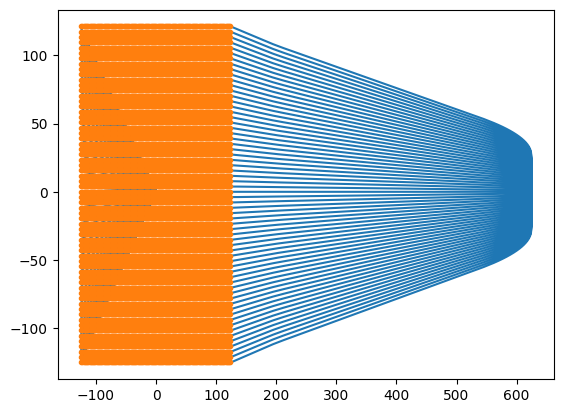

In [2]:
#@title 2D GRE in a brain phantom - sequence

experiment_id = 'gre2d'

# ======
# SETUP SYSTEM
# ======

# set the scanner hardware limits
sys = mr.Opts(
    max_grad=22, grad_unit='mT/m', max_slew=120, slew_unit='T/m/s',
    rf_ringdown_time=20e-6, rf_dead_time=100e-6,
    adc_dead_time=20e-6, grad_raster_time=10e-6)

# Create a sequence object based on the scanner limits
seq = mr.Sequence(sys)

# ======
# DEFINE TIMING, EVENTS, etc.
# ======

# Define FOV, resolution, flip angle, timing, etc.
fov = 256e-3; Nx = 64; Ny = Nx # FOV and resolution
Nrep = 1                        # number of repetition
Nslice = 1                      # number of slices
TE = 6e-3                       # echo time
TR = 20e-3                      # repetition time
alpha = 10                      # flip angle
sliceThickness = 3e-3           # slice thickness
sliceGap = 0                    # slice gap
readout_duration = 5.12e-3      # ADC duration
oversamp = 2                          # readout oversampling

# Create slice-selective RF pulse and gradient
rf, gz, _ = mr.make_sinc_pulse(flip_angle=alpha*np.pi/180, duration=3e-3, slice_thickness=sliceThickness, apodization=0.42, time_bw_product=4.0, system=sys,return_gz=True)
gzReph = mr.make_trapezoid(channel='z', area=-gz.area/2, duration=1e-3, system=sys) # gradient rephaser of the slice-selective gradient (gz)

# Define other gradients and ADC events
deltak = 1/fov
gx = mr.make_trapezoid(channel='x', flat_area=Nx*deltak, flat_time=readout_duration, system=sys) # readout gradient
adc = mr.make_adc(num_samples=oversamp*Nx, duration=gx.flat_time, delay=gx.rise_time, system=sys) # ADC
gxPre = mr.make_trapezoid(channel='x', area=-gx.amplitude*(adc.dwell*(adc.num_samples/2+0.5)+0.5*gx.rise_time), duration=1e-3, system=sys) # prephaser of the readout gradient (gx)

phaseAreas = (np.arange(0, Ny) - Ny / 2) * deltak
gy = mr.make_trapezoid(channel='y', area=np.max(np.abs(phaseAreas)), duration=mr.calc_duration(gxPre), system=sys) ;
peScales = phaseAreas/gy.area ;

# Gradient spoiling
gxSpoil = mr.make_trapezoid(channel='x', area=2*Nx*deltak,system=sys) ;
gzSpoil = mr.make_trapezoid(channel='z', area=4/sliceThickness, system=sys) ;

# Calculate timing
delayTE = np.ceil((TE - mr.calc_duration(gxPre) - gz.fall_time - gz.flat_time/2 - mr.calc_duration(gx)/2)/seq.grad_raster_time) * seq.grad_raster_time
delayTR = np.ceil((TR - mr.calc_duration(gz) - mr.calc_duration(gxPre) - mr.calc_duration(gx) - delayTE)/seq.grad_raster_time)*seq.grad_raster_time
assert(delayTE >= 0 )
assert(delayTR >= mr.calc_duration(gxSpoil, gy, gzSpoil) )

# ======
# CONSTRUCT SEQUENCE
# ======
for i in range(0, Ny):
  # RF spoiling (vary RF phase pseudo-randomly)
  rand_phase = np.mod(117 * (i**2 + i + 2), 360) * np.pi / 180
  rf.phase_offset = rand_phase
  adc.phase_offset = rand_phase
  seq.add_block(rf, gz) # slice-selective excitation
  seq.add_block(gxPre, mr.scale_grad(gy, peScales[i]), gzReph)
  seq.add_block(mr.make_delay(delayTE))
  seq.add_block(gx, adc) ;
  seq.add_block(mr.make_delay(delayTR), gxSpoil, mr.scale_grad(gy, -peScales[i]), gzSpoil)

(ok, error_report) = seq.check_timing()  # Check whether the timing of the sequence is correct
if ok:
    print("Timing check passed successfully")
else:
    print("Timing check failed. Error listing follows:")
    [print(e) for e in error_report]

# Plot k-space trajectory
k_traj_adc, k_traj, t_excitation, t_refocusing, t_adc = seq.calculate_kspace()

plt.figure()
plt.plot(k_traj[0],k_traj[1])
plt.plot(k_traj_adc[0],k_traj_adc[1],'.')

# Prepare the sequence output for the MRzero simulation
seq.set_definition('Name', 'gre2d')
seq.set_definition('FOV', [fov, fov, sliceThickness]) ;
seq.write(f"{experiment_id}.seq")

VoxelGridPhantom
size = tensor([0.2000, 0.2000, 0.0080])


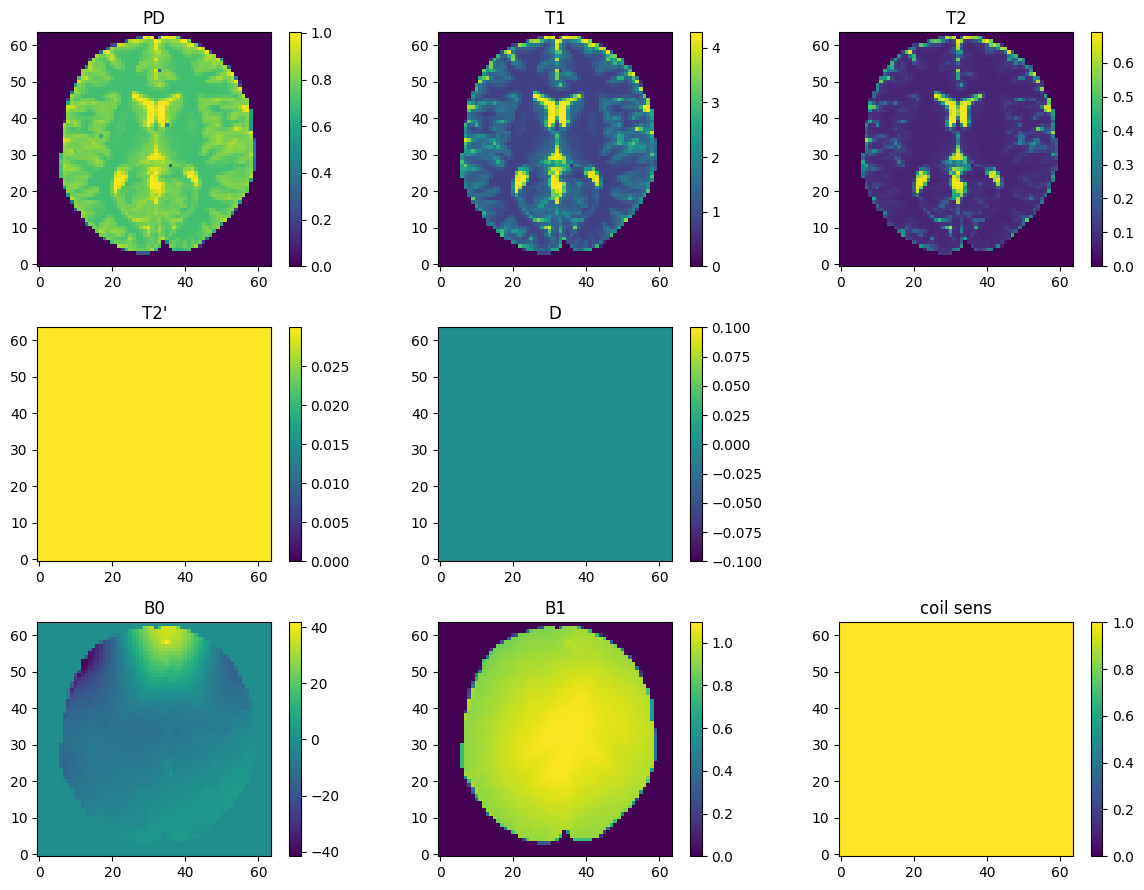

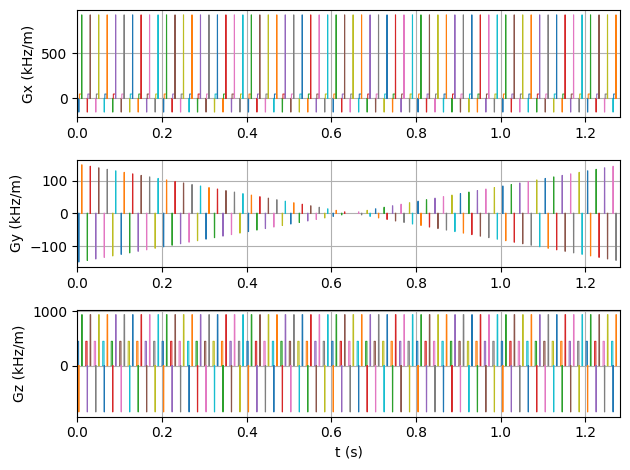

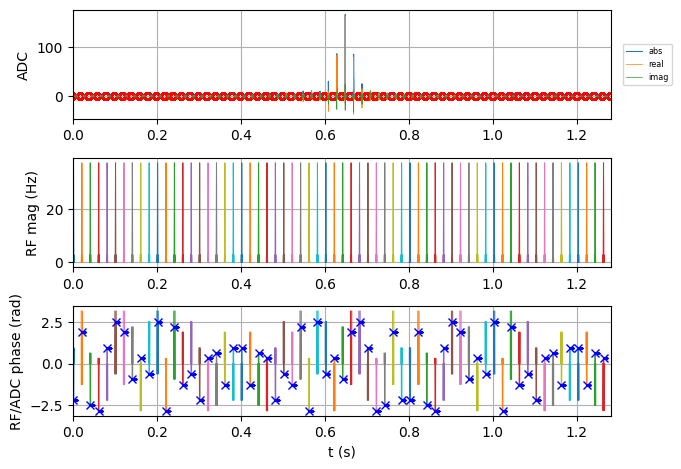

In [3]:
#@title 2D GRE in a brain phantom - simulation
dB0 = 0
sz = [64, 64]
# %% S4: SETUP SPIN SYSTEM/object on which we can run the MR sequence .seq from above
# (i) load a phantom object from file
obj_p = mr0.VoxelGridPhantom.load_mat('numerical_brain_cropped.mat')
obj_p = obj_p.interpolate(sz[0], sz[1], 1)
# Manipulate loaded data
obj_p.T2dash[:] = 30e-3
obj_p.D *= 0
obj_p.B0 *= 1    # alter the B0 inhomogeneity
# Store PD and B0 for comparison
PD = obj_p.PD
B0 = obj_p.B0
# Manipulate loaded data
obj_p.B0+=dB0
obj_p.D*=0
obj_p.plot()
# Convert Phantom into simulation data
obj_p=obj_p.build()

# %% SIMULATE  the external.seq file and add acquired signal to ADC plot
# Read in the sequence
seq0 = mr0.Sequence.import_file(f"{experiment_id}.seq")
#seq0.plot_kspace_trajectory()
# Simulate the sequence
graph=mr0.compute_graph(seq0, obj_p, 200, 1e-3)
signal=mr0.execute_graph(graph, seq0, obj_p, print_progress=False)
# PLOT sequence with signal in the ADC subplot
seq.plot(plot_now=False)
mr0.util.insert_signal_plot(seq=seq, signal =signal.numpy())
plt.show()


(-0.5, 63.5, -0.5, 63.5)

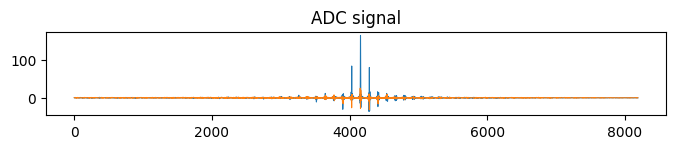

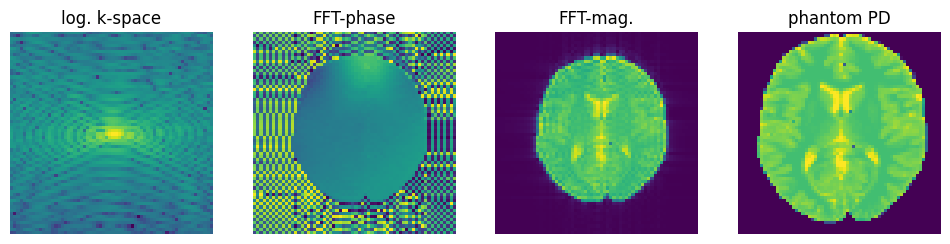

In [4]:
#@title 2D GRE in a brain phantom - manual reconstruction
# 2D FFT
import os
from google.colab import files
def fft_2d(x):
    return np.fft.ifftshift(np.fft.fftn(np.fft.ifftshift(x)))

kspace = np.reshape(signal, (Ny, oversamp*Nx))
kspace = np.array(kspace)
im = fft_2d(kspace)

fig = plt.figure(figsize=(8, 5))
plt.subplot(411)
plt.title('ADC signal')
plt.plot(np.real(signal), label='real')
plt.plot(np.imag(signal), label='imag')

plt.figure(figsize=(12, 10))
plt.tight_layout()
plt.subplot(141)
plt.title('log. k-space')
plt.imshow(np.log(np.abs(kspace[:,31:95]))); plt.axis('off')

plt.subplot(142)
plt.title('FFT-phase')
plt.imshow(np.angle(im[:,31:95]), vmin=-np.pi, vmax=np.pi, origin="lower"); plt.axis('off')

plt.subplot(143)
plt.title('FFT-mag.')
plt.imshow(np.abs(im[:,31:95]), origin="lower"); plt.axis('off')

plt.subplot(144)
plt.title('phantom PD')
plt.imshow(PD.squeeze().T, origin="lower"); plt.axis('off')

#### BART Installation and Compilation (2min30sec). Just need to run it once.

Here we install BART's dependencies, clone its repository from github, and compile it.

---
**💡Hint:💡**

- **`%%bash` Cells in Google Colab:**

  In Google Colab, `%%bash` cells allow you to run bash commands directly within your notebook.

  Simply prefix your cell with `%%bash`, and you can run any shell command, including calls to BART tools, just as you would in a terminal.

  If you only have a single command you can also prefix it with `!` for the same effect.

In [5]:
# Just need to run this cell once.
%%bash
# Install BART's dependencies
apt-get install -y make gcc libfftw3-dev liblapacke-dev libpng-dev libopenblas-dev &> /dev/null

# Clone BART (delete previous version)
[ -d /content/bart ] && rm -r /content/bart
git clone https://github.com/mrirecon/bart/ bart &> /dev/null

cd bart
git checkout "v0.9.00"
# Configuration
COMPILE_SPECS=" PARALLEL=1
                OPENBLAS=1
                BLAS_THREADSAFE=1"

printf "%s\n" $COMPILE_SPECS > Makefiles/Makefile.local

# Compile BART
make &> /dev/null && echo ok

ok


Note: switching to 'v0.9.00'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

HEAD is now at 672a840f bump version


#### Setup Environment for BART

After downloading and compiling BART, the next step simplifies the handling of BART's command line interface inside an ipython jupyter notebook. We add the BART directory to the PATH variable and include the python wrapper for reading *.cfl files:

In [6]:
import sys, os
os.environ['BART_TOOLBOX_PATH'] = f"{os.getcwd()}/bart"
os.environ['PATH'] = os.environ['BART_TOOLBOX_PATH'] + ":" + os.environ['PATH']
sys.path.append(os.environ['BART_TOOLBOX_PATH'] + "/python/")
from bart import bart
import cfl

Check BART setup:

In [7]:
%%bash
echo "# BART version: "
bart version

# BART version: 
v0.9.00


## BART Fundamentals
BART provides a number of tools for MR image reconstruction and multi-dimensional array manipulation. We can get a list of them by running `bart` with no arguments.

Note: The ! character indicates that the following cell should be executed in bash vs. the native python kernel. It is not necessary when running BART commands from your terminal.

In [8]:
# get a list of BART commands by running bart with no arguments:
! bart

Usage: bart [-l,--loop d] [-p,--parallel-loop d] [-s,--start d0:d1:...:dN] [-e,--end d0:d1:...:dN] [-t,--threads d] [-r,--ref-file <file>] [-M,--mpi] [-S] ...
BART. Available commands are:
avg         bench       bin         bitmask     cabs        calc        
caldir      calmat      carg        casorati    cc          ccapply     
cdf97       circshift   conj        conv        conway      copy        
cpyphs      creal       crop        delta       ecalib      ecaltwo     
epg         estdelay    estdims     estshift    estvar      extract     
fakeksp     fft         fftmod      fftrot      fftshift    filter      
flatten     flip        fmac        fovshift    homodyne    ictv        
index       invert      itsense     join        looklocker  lrmatrix    
mandelbrot  measure     mip         mnist       moba        mobafit     
morphop     multicfl    nlinv       nlmeans     nnet        noise       
normalize   nrmse       nufft       nufftbase   onehotenc   ones        
pattern 

### BART Command Structure

All BART commands are structured in the following way:

> **`bart`** + **`command`** + **`options`** + **`input / output`**

Each BART command consists of a number of optional arguments, followed by input and output files. To get some information about a command, use the -h flag. Optional arguments are indicated by brackets, and files are indicated by `<,>` symbols.

For example, the following command demonstrates the full suite of options for generating a numerical phantom in the image or k-space domain:

In [9]:
! bart phantom -h

Usage: phantom [-s d] [-S d] [-k] [-t <file>] [-G] [-T] [--NIST] [--SONAR] [--BRAIN] [--ELLIPSOID] [--ellipsoid_center d:d:d] [--ellipsoid_axes f:f:f] [-N d] [-B] [--FILE <file>] [-x d] [-g d] [-3] [-b] [-r d] [--rotation-angle f] [--rotation-steps d] [--coil ...] <output> 

Image and k-space domain phantoms.

-s nc                       nc sensitivities
-S nc                       Output nc sensitivities
-k                          k-space
-t file                     trajectory
-G                          geometric object phantom
-T                          tubes phantom
--NIST                      NIST phantom (T2 sphere)
--SONAR                     Diagnostic Sonar phantom
--BRAIN                     BRAIN geometry phantom
--ELLIPSOID                 Ellipsoid.
--ellipsoid_center d:d:d    x,y,z center coordinates of ellipsoid.
--ellipsoid_axes f:f:f      Axes lengths of ellipsoid.
-N num                      Random tubes phantom with num tubes
-B                          BART logo
-

## File formats and metadata

BART data files are (typically) stored in two files:

* A header (`.hdr`) file which contains metadata (dimensions, file type, etc.)

* A complex float (`.cfl`) file which contains the raw data.

The header file can be opened and read as a normal text file, while the raw data is a binary file. The raw data is a multi-dimensional array of single-precision complex floats, stored in col-major order with interleaved real and imaginary components.

### Writing to and from `.cfl` files

The `cfl` Python library has some helpful tools to save or load BART data into a numpy-compatible format. In the first example, we will create a complex float array in numpy and then load it into BART from the command line. In the second example, we generate an array and load it into Python via the cfl library.

In [10]:
A = np.array([1 + 1j, 2 + 3j, 3 + 5j])
cfl.writecfl('A', A)
! ls A.*
! bart show A

A.cfl  A.hdr
+1.000000e+00+1.000000e+00i	+2.000000e+00+3.000000e+00i	+3.000000e+00+5.000000e+00i


Note that when calling BART functions from the command-line, you do not need to include the extension. This is because BART understands to look for both the `.cfl` and `.hdr` files.

In [11]:
! bart ones 2 3 3 B
B = cfl.readcfl('B')
B

array([[1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j],
       [1.+0.j, 1.+0.j, 1.+0.j]], dtype=complex64)

Because the header file is a text file, we can directly print it:

In [12]:
! cat B.hdr

# Dimensions
3 3 
# Command
ones 2 3 3 B 
# Files
 >B
# Creator
BART v0.9.00


Although not discussed here, BART can write to other file formats that might not have a text header. Thus, it is better to use the show command:

In [13]:
! bart show -m B

Type: complex float
Dimensions: 16
AoD:	3	3	1	1	1	1	1	1	1	1	1	1	1	1	1	1


Our dataset is 16-dimensional, but only the first two dimensions are non-singleton.

By convention, the dimensions are `[X, Y, Z, C, M, T, F, ...]`,
where `(X, Y, Z)` are the spatial matrix dimensions,  
`C` and `M` are the coil dimensions and ESPIRiT maps dimensions, respectively,  
`T` and `F` are used for echo times and coefficient dimensions,   
followed by other higher order dimensions such as flow encoding, etc.

When using the Python interface, note that higher-order singleton dimensions will be squeezed and thus might not show up as 16-dimensional.

## Data Conversion: python array to BART Format

So now that we have some basic BART knowledge, we'll convert our data from .mat files to a BART-compatible format. You can find more information on the Raw Data structure of the scanner [here](https://github.com/josalggui/MaRGE/wiki/Raw-Data-structure).

Use `bart.writecfl` to write data in BART format

This process makes our data ready for further processing with BART tools.

In [14]:
cfl.writecfl('kspace', kspace)

## Data Exploration

Now that we've imported our data, let's examine its current dimensions using the BART `show` command with the `-m` flag.

In [15]:
%%bash
bart show -m kspace

Type: complex float
Dimensions: 16
AoD:	64	128	1	1	1	1	1	1	1	1	1	1	1	1	1	1


## Data Reformatting

As we  can see, our data doesn't match the expected BART data format. We'll use the BART transpose command to reformat it.

### BART Data Format for Cartesian Data

For our Cartesian data, BART expects the following dimension order:

| Index | Dimension Name | Description |
|-------|----------------|-------------|
| 0     | READ_DIM       | Readout dimension |
| 1     | PHS1_DIM       | First phase-encoding dimension |
| 2     | PHS2_DIM       | Second phase-encoding dimension |
| 3     | COIL_DIM       | Receiver coil dimension |
| 4     | MAPS_DIM       | Maps dimension (e.g., for multiple sets of sensitivity maps) |
| 5     | TE_DIM         | Echo time dimension |
| 6     | COEFF_DIM      | Coefficient dimension (e.g., for parameter maps) |
| ...   | ...            | ... |

### Using BART Transpose Command

To reformat our data, we'll use the BART transpose command. You can view the help for this command using:

In [16]:
%%bash
bart transpose -h

Usage: transpose dim1 dim2 <input> <output> 

Transpose dimensions {dim1} and {dim2}.

-h  help


Note that when calling BART functions from the command-line, you do not need to include the extension. This is because BART understands to look for both the `.cfl` and `.hdr` files.    
So let's get started reformatting our k-space data! _Remember: Indexing starts at 0!_

- Dimension `0` and `1`

In [17]:
%%bash
bart transpose 0 1 kspace kspace_transposed

### Verifying Data Format

After reformatting the data, we can again check the format using the `bart show -m` command.

In [18]:
%%bash
bart show -m kspace_transposed

Type: complex float
Dimensions: 16
AoD:	128	64	1	1	1	1	1	1	1	1	1	1	1	1	1	1


## First Look at the k-space

We'll examine our simulated 2D GRE dataset for offline reconstruction:

1. Perform FFT along the third dimension
2. Visualize the resulting k-space data

### Using BART FFT Command

To apply FFT, we'll use the BART `fft` command. The BART `fft` command requires a bitmask to select dimensions for processing:

- Use `bart bitmask` to generate the required bitmask for dimension `0` and `1`
- Specify dimensions where FFT should be applied
- We use the `-i` and `-u` flags

Thus, we performed an inverse (-i) unitary (-u) Fast Fourier Transform on the image dimensions (0, 1) specified by the bitmask = 2.^0 + 2.^1 = 3.

Instead of using for loops, BART data operates on bitmasks. To operate on a particular array dimension, a bitmask specifies the active dimensions. This is a powerful approach for perfoming multi-dimensional operations, as all the tools will work on arbitrarily chosen dimensions.

BART also provides a command-line tool to calculate the bitmasks for specific dimensions.

For example, calculate bitmask for active dimensions 0 and 1:     
`bart bitmask 0 1`


In [19]:
! bart bitmask -h

Usage: bitmask [-b] [dim1 ... dimN ] 

Convert between a bitmask and set of dimensions.

-b    dimensions from bitmask, use with exactly one argument
-h    help


In [20]:
! bart fft -h

Usage: fft [-u] [-i] [-n] bitmask <input> <output> 

Performs a fast Fourier transform (FFT) along selected dimensions.

-u    unitary
-i    inverse
-n    un-centered
-h    help


Now it's your turn!

---

**💡Hint:💡**

- **Subshell Syntax**

  In shell scripting, the syntax `$(command)` is used to execute a command in a subshell and capture its output.
  
  For example, `$(bart bitmask ...)` runs the `bart bitmask` command and substitutes its output directly into the command line where it is called.
  
  This can be useful when generating bitmasks for use with other BART commands or using a combination of BART commands. <!-- Maybe command example-->

In [21]:
#@title FFT reconstruction with BART
%%bash
bart fft -u -i $(bart bitmask 0 1) kspace_transposed img
bart show -m img

Type: complex float
Dimensions: 16
AoD:	128	64	1	1	1	1	1	1	1	1	1	1	1	1	1	1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

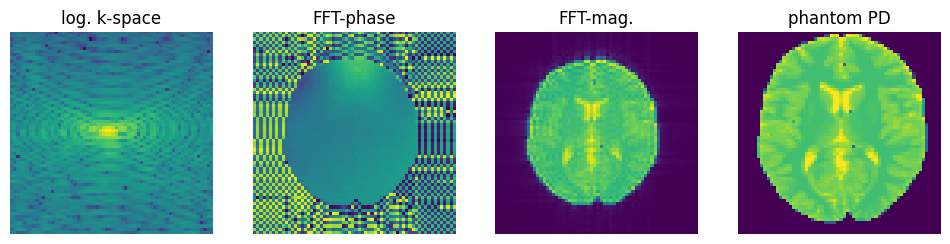

In [22]:
#@title Visualization
ksp_array = cfl.readcfl('kspace_transposed')
plt.figure(figsize=(12, 10))
plt.subplot(141)
plt.title('log. k-space')
plt.imshow(np.log(np.fliplr(np.abs(np.rot90(ksp_array[31:95,:]))))); plt.axis('off')
img_array = cfl.readcfl('img')
plt.subplot(142)
plt.title('FFT-phase')
plt.imshow(np.angle(np.fliplr(np.rot90(img_array[31:95,:]))), vmin=-np.pi, vmax=np.pi, origin="lower"); plt.axis('off')
plt.subplot(143)
plt.title('FFT-mag.')
plt.imshow(np.abs(np.fliplr(np.rot90(img_array[31:95,:]))), origin="lower"); plt.axis('off')
plt.subplot(144)
plt.title('phantom PD')
plt.imshow(PD.squeeze().T, origin="lower"); plt.axis('off')
plt.savefig("bart_recon_1.png")
files.download("bart_recon_1.png")